# An EXP simulation using pyEXP from a notebook: a disk-halo simulation

We will assume that you are running the Docker EXP image.  If not, make sure that you `pip install k3d` for the final three-dimensional
rendering.

We begin by importing `pyEXP` and friends and setting the working directory.

In [59]:
import os
import yaml
import pyEXP
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 9]

# Make a working directory for output
os.chdir('DiskHalo')

# Print the current working directory for reference
print(os.getcwd())

/home/weinberg/Projects/pyEXP-examples/Tutorials/EXP/DiskHalo


FileNotFoundError: [Errno 2] No such file or directory: 'DiskHalo'

## Running EXP

If you have a full EXP install or are using the Docker image, you can run EXP from inside Jupyter to generate new simulations.  We'll do
and example here using the periodic cube.

### Generating initial conditions

The full install has a body generator for the galaxy initial conditions called `gendisk`.   This code uses an Eddington inversion to
generate spherical halo initial condtions and Jeans equations to generate disk initial conditions.  It will generate the cylindrical
basis at the same time.  This step takes some time, so please be prepared to wait for 10 or 15 minutes.  Try it as follows:

In [196]:
! mpirun gendisk --ASCALE=0.01 --HSCALE=0.002 --scale_length=0.01 --scale_height=0.002 --LMAX=2 --MMAX=2 --NMAXH=6 --NMAXD=8 --NODD=2 --RMIN=0.00001 --nhalo=40000 --ndisk=40000 --NDP=1 --suffix="" --expcond --ignore --cachefile=eof.cache.test

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%% Node, process, and communicator assignment %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
  Node # |             Hostname |      PID |     Status
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
       0 |         9a015386ece6 |    13618 |       ROOT
       1 |         9a015386ece6 |    13619 |    WORKER 0
       2 |         9a015386ece6 |    13620 |    WORKER 1
       3 |         9a015386ece6 |    13621 |    WORKER 2
DiskType is <exponential>
---- Number of threads=1
---- Maximum # threads=1
---- SLGridSph::ReadH5Cache: parameter lmax: wanted 2 found 4
---- SLGridSph::WriteH5Cache cache file <.slgrid_sph_cache> exists
---- SLGridSph::WriteH5Cache: existing file backed up to <.slgrid_sph_cache.bak>
---- SLGridSph::WriteH5Cache: wrote <.slgrid_sph_cache>
---- EmpCylSL::make_sl(): making SLGridSph with <Ex

We have provided a sample `exp` configuration file in this working directory.  The default name for a configuration file is
`config.yml`.  This run will take under an hour; and as little as 10 minutes on a modern laptop.  So be prepared to take a short
break.  For maximum speed change `X` in the `-np X` argument to `mpirun` to the number of cores available in your CPU.

The first shell command below empties the data directory, and the next is the`exp` launch command:

In [ ]:
%%time
! rm data/*
! mpirun -np 4 exp

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#   Node name           PID         Executable                              
-   ---------           ---         ----------                              
0   9a015386ece6        14633       exp                                     
1   9a015386ece6        14634       exp                                     
2   9a015386ece6        14635       exp                                     
3   9a015386ece6        14636       exp                                     
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%% This is EXP 7.7.28 %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%% Repository URL | https://github.com/EXP-code/EXP                         %
%%%%% Current branch | pyEXPfix                 

## Read the log file

and plot the virial equilibrium as a function of time

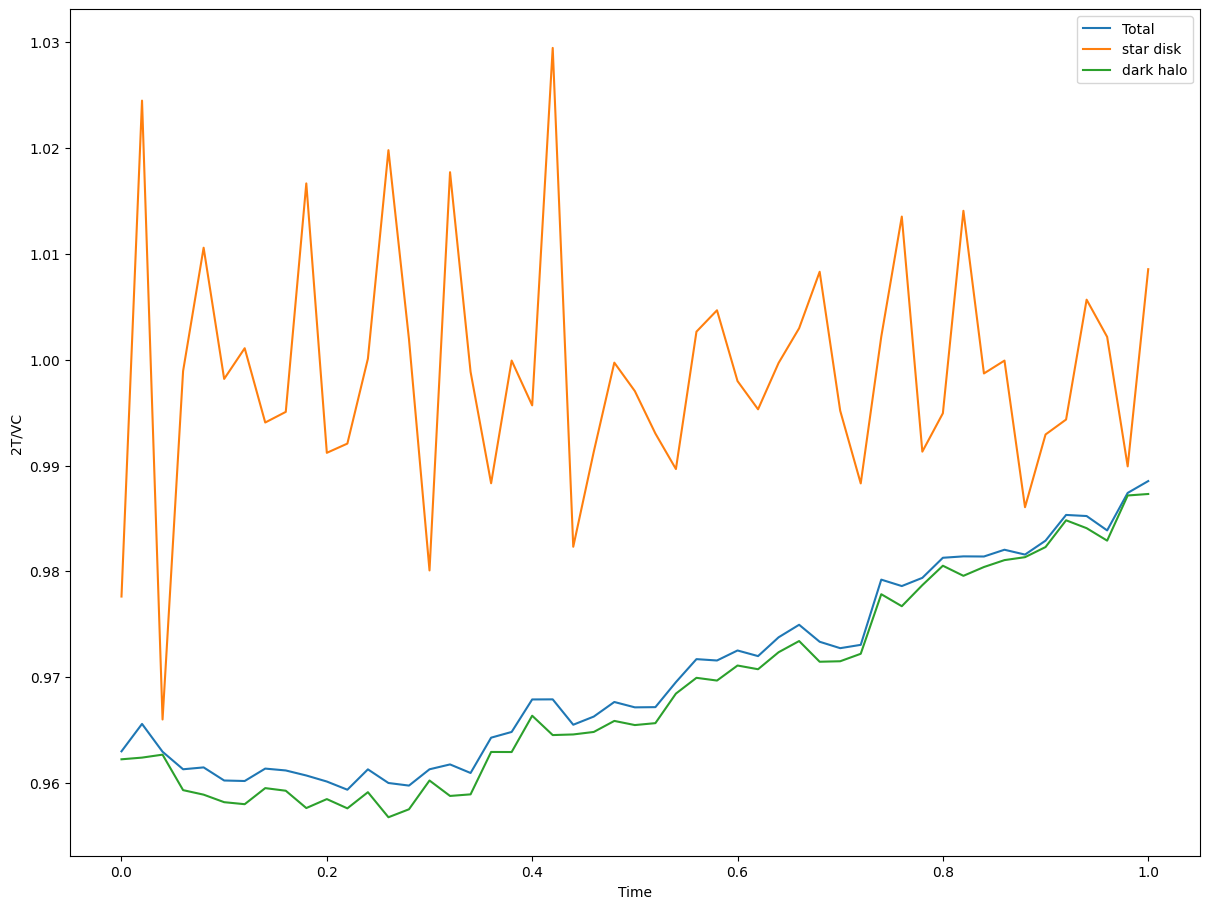

In [200]:
# This parses the 

def parseLog(runtag):
    file = open("data/OUTLOG." + runtag)
    # Get the column names
    labs = file.readlines()[2:3][0].split('|')
    # Get the data
    vals = np.loadtxt("data/OUTLOG." + runtag, delimiter='|', skiprows=6)
    # Make a dictionary of columns
    data = {}
    for i in range(len(labs)):
        data[labs[i].strip()] = vals[:,i]
    return data

data = parseLog('run0')

plt.plot(data['Time'], data['2T/VC'], label='Total')
plt.plot(data['Time'], data['star disk 2T/VC'], label = 'star disk')
plt.plot(data['Time'], data['dark halo 2T/VC'], label = 'dark halo')
plt.legend()
plt.tight_layout()
plt.xlabel('Time')
plt.ylabel('2T/VC')
plt.show()

## Reading the disk coefficients
This is a test of the coefficients created by the `EXP-examples/DiskHalo` run.

In [201]:
# Reread the coefs from the file.  These are new HDF5 coefficients sets.
#
coefs = pyEXP.coefs.Coefs.factory('data/outcoef.star disk.run0')

print("Got coefs for name=", coefs.getName())

Got coefs for name= star disk


## Now get the time vector and data tensor. Plot some coefficient series as a function of time.

In [202]:
times = coefs.Times()
data  = coefs.getAllCoefs()

print("The data sizes and coefficient orders are:")
# print(data.shape[0], data.shape[1], data.shape[2], nmaxx, nmaxy, nmaxz)
print("M, N, T:", data.shape)

The data sizes and coefficient orders are:
M, N, T: (3, 8, 501)


### Finally, plot some coefficient values...

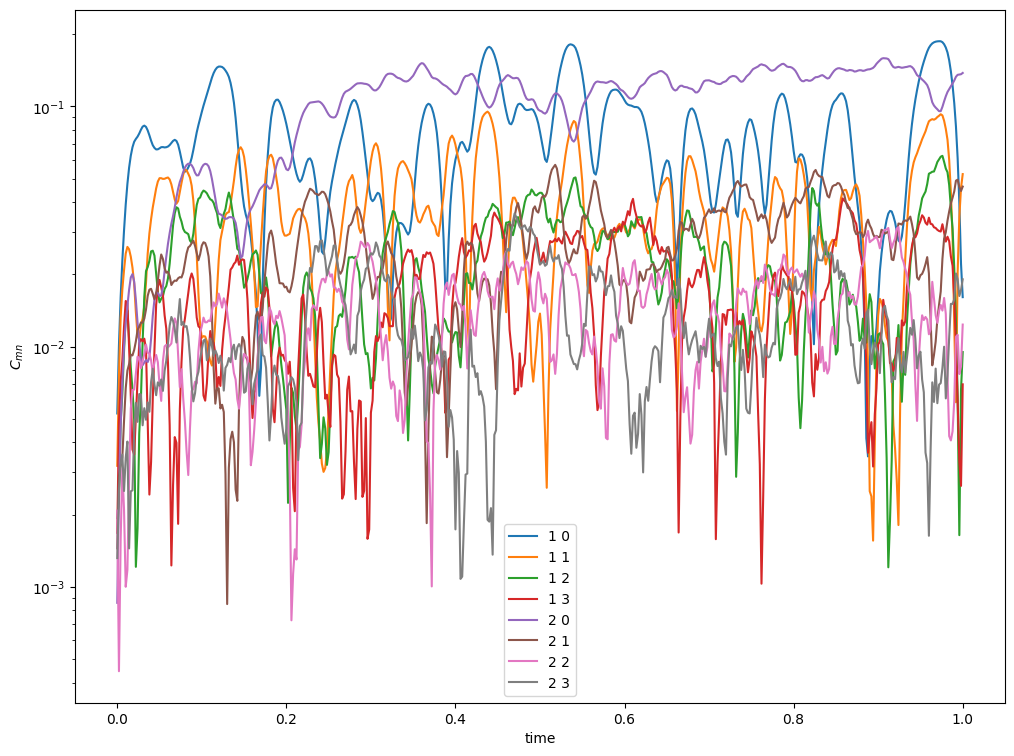

In [214]:
for m in range(1, data.shape[0]):
    for n in range(4):
        plt.semilogy(times, np.abs(data[m, n, :]), label='{} {}'.format(m, n))

plt.xlabel('time')
plt.ylabel(r'$C_{mn}$')
plt.legend()
plt.show()

## Try loading EXP config with pyYAML

In [204]:
with open('config.yml', 'r') as f:
    yaml_db = yaml.load(f, Loader=yaml.FullLoader)

In [205]:
# There is only one component here at index = 0

config = yaml.dump(yaml_db['Components'][1]['force'])
        
print(config)

id: cylinder
parameters:
  acyl: 0.01
  cachename: eof.cache.test
  hcyl: 0.002
  lmaxfid: 48
  mmax: 2
  ncylnx: 256
  ncylny: 128
  ncylodd: 2
  nmax: 8
  nmaxfid: 48



## Construct the cylindrical basis

In [206]:
basis = pyEXP.basis.Basis.factory(config)

---- EmpCylSL::ReadH5Cache: read <eof.cache.test>
---- EmpCylSL::read_cache: table forwarded to all processes
Cylindrical::orthoTest: worst=9.03892e-05


In [207]:
times = coefs.Times()

In [208]:
# Slice through the cube perpendicular to the z axis
rmin  = -0.04
rmax  = 0.04
pmin  = [ rmin, rmin, 0]
pmax  = [ rmax, rmax, 0]
grid  = [   40,    40,  0]

fields = pyEXP.field.FieldGenerator(times, pmin, pmax, grid)

surfaces = fields.slices(basis, coefs)

In [209]:
import math

def getLim(x):
    """ Get the one signifcant figure upper/lower limit """
    om = 10.0**np.floor(np.log10(np.abs(x)))
    if x < 0.0:
        return (np.floor(x/om)*om, om)
    else:
        return (np.ceil(x/om)*om, om)

In [210]:
densmin =  1.0e30
densmax = -1.0e30

for v in surfaces:
    for k in surfaces[v]: 
        # print(v, k)
        if k=='dens':
            densmin = min(densmin, np.min(surfaces[v]['dens']))
            densmax = max(densmax, np.max(surfaces[v]['dens']))

print('Density range', densmin, densmax)

Density range -2920.2932 63655.168


## Slice through the cube perpendicular to the z axis and render

In [211]:
from matplotlib import cm, ticker

# Get the evaluation grid
dr = (rmax-rmin)/(40-1)
rr = np.arange(rmin, rmax+0.1*dr, dr)
xv, yv = np.meshgrid(rr, rr)
cnt = 0

# Round to one sig figfor v in surfaces:

dmax, ommax = getLim(math.log10(densmax))
print(dmax)

# Make levels
levs = 10.0**np.arange(dmax-4, dmax+0.01, 0.25)

for v in times:
    cc = plt.contourf(xv, yv, surfaces[v]['dens'].transpose(), levels=levs, locator=ticker.LogLocator())
    plt.colorbar(cc)
    plt.title('Time={:4.3f}'.format(v))
    plt.savefig('disk_{:04d}.png'.format(cnt))
    plt.close()
    cnt += 1

5.0


/tmp/ipykernel_6432/2308027446.py:18: UserWarning: Log scale: values of z <= 0 have been masked
  cc = plt.contourf(xv, yv, surfaces[v]['dens'].transpose(), levels=levs, locator=ticker.LogLocator())


#### Make a movie from the rendered frames

This requires `ffmpeg` to be installed.  It *is* installed in the Docker image...

In [212]:
os.system('ffmpeg -y -i \'disk_%04d.png\' disk_{0}.mp4'.format('run0'))

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

0

#### Play the movie

In [213]:
from IPython.display import Video
Video('disk_{}.mp4'.format('run0'), embed=True, width=800)

### A few comments



### A 3d rendering for fun

Make the volume slices

In [215]:
import k3d
from k3d import matplotlib_color_maps

# Slice through the cube perpendicular to the z axis
rmin  = -0.04
rmax  = 0.04
hmin  = -0.005
hmax  =  0.005
pmin  = [ rmin, rmin, hmin]
pmax  = [ rmax, rmax, hmax]
grid  = [   40,   40,   40]

# Only render the final time
fields = pyEXP.field.FieldGenerator(times[-1:], pmin, pmax, grid)

volumes = fields.volumes(basis, coefs)

Take the log of the density field and find some good contour levels

In [216]:
# levels for rendering 
llevs = np.arange(dmax-2, dmax+0.01, 0.5)
levs = 10.0**llevs
print("Level surfaces:", levs, llevs)

v = volumes[times[-1]]['dens']
v[v<levs[0]] = 0.5*levs[0]
v = np.log10(v)

Level surfaces: [  1000.           3162.27766017  10000.          31622.77660168
 100000.        ] [3.  3.5 4.  4.5 5. ]


Finally, make the 3d rendering using `k3d`

In [217]:
plot = k3d.plot(axes=['z', 'y', 'x'])
color_map = k3d.basic_color_maps.Jet

minlev = dmax-2.0
maxlev = dmax

for lev in llevs:
    plot += k3d.marching_cubes(v, level=lev, attribute=[lev], color_map=color_map, color_range=[minlev, maxlev],
                            opacity=0.25,
                            xmin=hmin, xmax=hmax,
                            ymin=rmin, ymax=rmax,
                            zmin=rmin, zmax=rmax,
                            compression_level=9,
                            flat_shading=False)
plot.display()
plot.camera = [0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 1, 0, 0]



Output()